# Misunderstandings! In the Emergency Room.*

( * A bad Panic! At the Disco Reference. )

## Setup

As always, let's import the packages we need and set a random seed in NumPy, which will generate the same figure you see in the textbook. If you want to run this with truly random data, just comment out the `np.random.seed()` line.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

## Simulate our dataset

In [2]:
n_patients = 1000

# Generate ages from a gamma distribution, scaled and truncated to 18-99
ages = (np.random.gamma(3, 8, n_patients) + 18).astype(int)
ages = np.clip(ages, 18, 98)

baseline_adverse_rate = 0.20
adverse_events = np.random.random(n_patients) < baseline_adverse_rate

df = pd.DataFrame({
    'age': ages,
    'adverse_event': adverse_events.astype(int)
})

# Now inject the problematic data: unknown ages coded as 99
n_unknown = 50  # 5% of patients have unknown age
unknown_indices = np.random.choice(df.index, n_unknown, replace=False)

# The '99' patients have much higher adverse event rate (80%)
df.loc[unknown_indices, 'age'] = 99
df.loc[unknown_indices, 'adverse_event'] = (np.random.random(n_unknown) < 0.80).astype(int)

# Look at the first 10 patients
df.head(10)

,age,adverse_event
0,46,0
1,37,0
2,36,0
3,36,0
4,67,0
5,51,0
6,99,1
7,47,0
8,42,1
9,22,0


First, we'll look to see if we find different rates of adverse events if we bin by age:

age
(18, 40]    0.198830
(40, 60]    0.201807
(60, 80]    0.157303
(80, 99]    0.723077
Name: adverse_event, dtype: float64


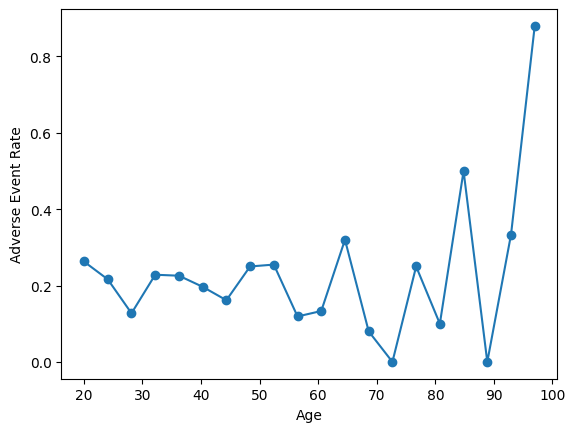

In [3]:
print(df.groupby(pd.cut(df['age'], bins=[18, 40, 60, 80, 99]), observed=True)['adverse_event'].mean())

# Adverse event rate by age
age_bins = pd.cut(df['age'], bins=20)
adverse_by_age = df.groupby(age_bins, observed=True)['adverse_event'].mean()

# Get the midpoint of each age bin for plotting
bin_midpoints = [interval.mid for interval in adverse_by_age.index]

plt.plot(bin_midpoints, adverse_by_age.values, 'o-')
plt.xlabel('Age')
plt.ylabel('Adverse Event Rate')
plt.show()

Wow, looks like people in the 80-99 bucket have a much higher incidence of adverse events! However, the problem becomes obvious when we look at the age distribution:

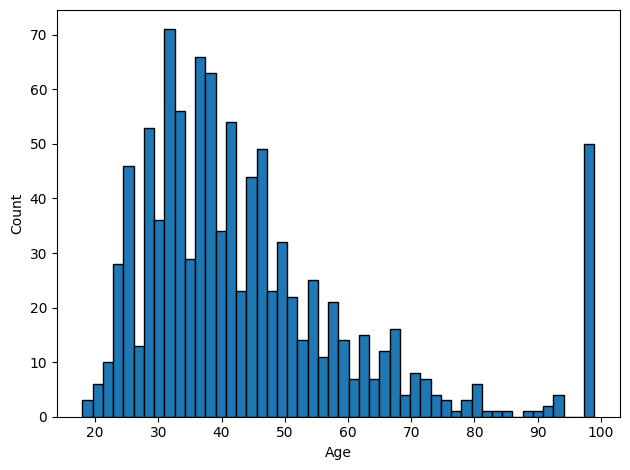

In [4]:
plt.hist(df['age'], bins=50, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In this case, we should exclude all of the patients whose ages are exactly 99. Unfortunately, this means we will also lose people who were legitimately 99 years old -- underscoring the importance of smartly choosing ways to encode missing values (e.g., with NaN)!

In [5]:
df_clean = df[df['age'] != 99] # filter out anyone whose age is equal to 99

print(df.groupby(pd.cut(df_clean['age'], bins=[18, 40, 60, 80, 99]), observed=True)['adverse_event'].mean())

age
(18, 40]    0.198830
(40, 60]    0.201807
(60, 80]    0.157303
(80, 99]    0.200000
Name: adverse_event, dtype: float64


As you can see, now the rate of adverse events is much more even across ages once we exclude those individuals that were erroneously coded with 99.